In [104]:
%matplotlib inline
import copy
import csv
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image, ImageFile
from skimage.util import random_noise
from sklearn.metrics import ConfusionMatrixDisplay,classification_report,confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from torch.optim import lr_scheduler
from torch.utils.data import ConcatDataset, DataLoader, Dataset
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

ImageFile.LOAD_TRUNCATED_IMAGES = True

import warnings

from tqdm import tqdm

warnings.filterwarnings("ignore")


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
random_seed = 12345

In [2]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)


g = torch.Generator()
g.manual_seed(0)

In [3]:
import zipfile
with zipfile.ZipFile("chest_xray_pre-processed.zip","r") as zip_ref:
    zip_ref.extractall("chest_xray_pre-processed")

In [4]:
PATH = "chest_xray_pre-processed/chest_xray_pre-processed"

In [5]:
train_ds = ImageFolder(
    PATH + "/train",
    transform=transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomRotation(10),
            transforms.RandomGrayscale(),
            transforms.RandomAffine(translate=(0.05, 0.05), degrees=0),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
)
val_ds = ImageFolder(
    PATH + "/val",
    transform=transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
)

len(train_ds), len(val_ds)

(4257, 975)

## Adding Gaussian Noise

In [6]:
# https://discuss.pytorch.org/t/how-to-add-noise-to-mnist-dataset-when-using-pytorch/59745/2
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + "(mean={0}, std={1})".format(
            self.mean, self.std
        )

## Managing the dataset imbalance

In [10]:
TRAIN_DIR = "chest_xray_pre-processed/chest_xray_pre-processed/train"


IMAGE_SIZE = 224 # Image size of resize when applying transforms.
BATCH_SIZE = 32
NUM_WORKERS = 4 # Number of parallel processes for data preparation.
def get_augmented_data():
    sample1 = ImageFolder(TRAIN_DIR, 
                        transform = transforms.Compose([transforms.Resize((224,224)),
                                            transforms.RandomRotation(10),
                                            transforms.RandomGrayscale(),
                                            transforms.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                            AddGaussianNoise(0., 1.)
                                           ]))

    sample2 = ImageFolder(TRAIN_DIR, 
                          transform=transforms.Compose([transforms.Resize((224,224)),
                                                transforms.RandomGrayscale(),
                                                transforms.RandomAffine(translate=(0.1,0.05), degrees=10),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                                AddGaussianNoise(0., 1.)
                                             ]))

    sample3 = ImageFolder(TRAIN_DIR, 
                          transforms.Compose([transforms.Resize((224,224)),
                                                transforms.RandomRotation(15),
                                                transforms.RandomGrayscale(p=1),
                                                transforms.RandomAffine(translate=(0.08,0.1), degrees=15),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                                AddGaussianNoise(0., 1.)
                                               ]))
    sample4 = ImageFolder(TRAIN_DIR, 
                          transforms.Compose([transforms.Resize((224,224)),
                                                transforms.RandomRotation(15),
                                                transforms.RandomGrayscale(p=1),
                                                transforms.RandomAffine(translate=(0.09,0.2), degrees=17),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                                AddGaussianNoise(0., 1.)
                                               ]))


    normal_1, _ = train_test_split(sample2, test_size= 3377/(880+3377), shuffle=False)
    normal_2, _ = train_test_split(sample3, test_size= 3377/(880+3377), shuffle=False)
    normal_3, _ = train_test_split(sample4, test_size= 3000/(880+3377), shuffle=False)

    train_dataset = ConcatDataset([sample1, normal_1, normal_2, normal_3])
    return train_dataset

In [11]:
train_dataset = get_augmented_data()

In [12]:
batch_size = 16

train_dl = DataLoader(train_ds, batch_size, shuffle=True, worker_init_fn=seed_worker)
val_dl = DataLoader(val_ds, batch_size, worker_init_fn=seed_worker)
loaders = {"train": train_dl, "val": val_dl}
dataset_sizes = {"train": len(train_ds), "val": len(val_ds)}

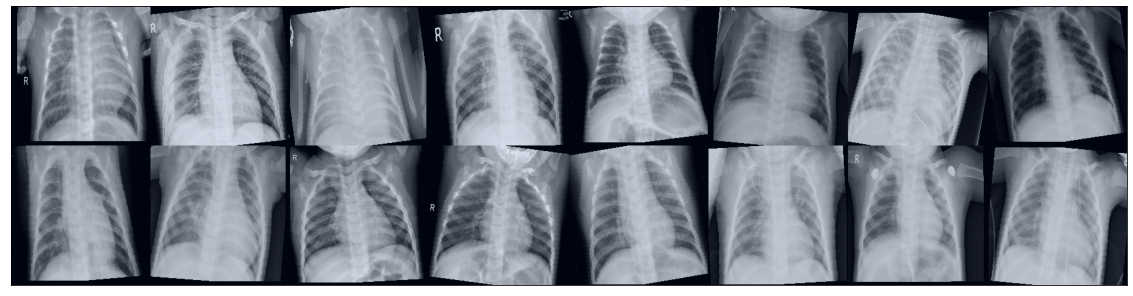

In [13]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(20, 14))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(
            make_grid(images[:60], nrow=8, padding=0, normalize=True).permute(1, 2, 0)
        )
        break


show_batch(train_dl)

## Model Training

In [14]:
model = torch.load("Finetuning_Stage2.pt")
model.to(device);

In [15]:
for param in model.parameters():
    param.requires_grad = False

in_features = model.classifier.in_features

model.classifier = nn.Linear(in_features, 2)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)

In [17]:
losses = {"train": [], "val": []}
accuracies = {"train": [], "val": []}


def train(model, criterion, optimizer, scheduler, epochs):
    since = time.time()
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(epochs):
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in loaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outp = model(inputs)
                    _, pred = torch.max(outp, 1)
                    loss = criterion(outp, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(pred == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            if phase == "train":
                print("Epoch: {}/{}".format(epoch + 1, epochs))
            print("{} - loss:{}, accuracy{}".format(phase, epoch_loss, epoch_acc))

            if phase == "val":
                print(
                    "Time: {}m {}s".format(
                        (time.time() - since) // 60, (time.time() - since) % 60
                    )
                )

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
        scheduler.step()
    time_elapsed = time.time() - since
    print("Training Time {}m {}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best accuracy {}".format(best_acc))

    model.load_state_dict(best_model)
    return model

In [18]:
model.to(device)
epochs = 15
model = train(model, criterion, optimizer, scheduler, epochs)

Epoch: 1/15
train - loss:0.06751440092320994, accuracy0.9760394644115574
val - loss:0.03809914735886149, accuracy0.9856410256410256
Time: 4.0m 26.349294185638428s
Epoch: 2/15
train - loss:0.06943614043061623, accuracy0.9767441860465117
val - loss:0.07933698517621825, accuracy0.9702564102564103
Time: 8.0m 45.13005018234253s
Epoch: 3/15
train - loss:0.06279169024316787, accuracy0.9779187221047687
val - loss:0.04533531059860252, accuracy0.9805128205128205
Time: 13.0m 3.9901607036590576s
Epoch: 4/15
train - loss:0.05515934938881381, accuracy0.9835564951844022
val - loss:0.05350311442830552, accuracy0.9774358974358974
Time: 17.0m 23.152445554733276s
Epoch: 5/15
train - loss:0.03925786761385742, accuracy0.9875499177824759
val - loss:0.03871305285809705, accuracy0.9815384615384616
Time: 21.0m 41.04412794113159s
Epoch: 6/15
train - loss:0.04721588938664807, accuracy0.9856706600892647
val - loss:0.06771318323631138, accuracy0.9743589743589743
Time: 25.0m 59.06865453720093s
Epoch: 7/15
train - l

## Model Evaluation on Test Set

In [81]:
testset = ImageFolder(
    PATH + "/test",
    transform=transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
)

In [82]:
test_dl = DataLoader(testset, batch_size=256)
model.to(device);

In [83]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

In [84]:
def validation(batch):
    images, labels = batch
    images, labels = images.to(device), labels.to(device)
    output = model(images)
    loss = F.cross_entropy(output, labels)
    acc, predictions = accuracy(output, labels)

    return {
        "valid_loss": loss.detach(),
        "valid_accuracy": acc.detach(),
        "predictions": predictions.detach(),
        "labels": labels.detach(),
    }

In [85]:
@torch.no_grad()
def test_predict(model, test_dataloader):
    model.eval()

    outputs = [validation(batch) for batch in test_dataloader]
    batch_losses = [x["valid_loss"] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x["valid_accuracy"] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()

    batch_preds = [pred for x in outputs for pred in x["predictions"].tolist()]
    batch_labels = [label for x in outputs for label in x["labels"].tolist()]

    print(
        "test_loss: {:.4f}, test_acc: {:.4f}".format(
            epoch_loss.item(), epoch_acc.item()
        )
    )

    return batch_preds, batch_labels

In [86]:
preds, labels = test_predict(model, test_dl)

test_loss: 0.3488, test_acc: 0.9189


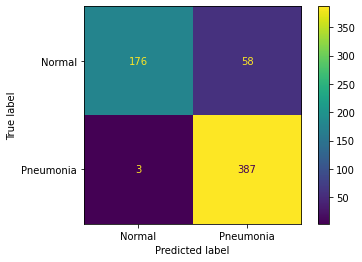

In [87]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Normal", "Pneumonia"]
)
disp.plot()

In [88]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.98      0.75      0.85       234
           1       0.87      0.99      0.93       390

    accuracy                           0.90       624
   macro avg       0.93      0.87      0.89       624
weighted avg       0.91      0.90      0.90       624



In [89]:
torch.save(model, "gaussian_noise_explanation.pt")

## Evaluation on new dataset

In [90]:
import zipfile
with zipfile.ZipFile("chest_xray_dataset2.zip","r") as zip_ref:
    zip_ref.extractall("chest_xray_dataset2")

In [94]:
testset2 = ImageFolder('chest_xray_dataset2/chest_xray_dataset2', 
                           transform=torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)), 
                                                 torchvision.transforms.ToTensor(),
                                                 torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),                                                               
                                                 
                                                ]))

In [95]:
idx2class = {v: k for k, v in testset2.class_to_idx.items()}
idx2class

{0: 'Normal', 1: 'Pneumonia'}

In [96]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict
print("Distribution of classes: \n", get_class_distribution(testset2))

Distribution of classes: 
 {'Normal': 280, 'Pneumonia': 289}


In [97]:
test_dl = DataLoader(testset2, batch_size=32)
model.to(device);

In [98]:
preds,labels = test_predict(model, test_dl)

test_loss: 2.6680, test_acc: 0.5742


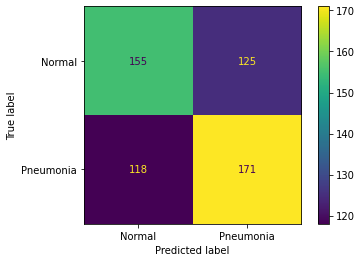

In [102]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Normal", "Pneumonia"]
)
disp.plot()

In [103]:

print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.57      0.55      0.56       280
           1       0.58      0.59      0.58       289

    accuracy                           0.57       569
   macro avg       0.57      0.57      0.57       569
weighted avg       0.57      0.57      0.57       569

